In [30]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import fsolve
import shutil
from tqdm import tqdm
import time
import imageio
import moviepy.editor as mp
save_plots = True
bif_value = 0.333800508

import warnings
warnings.filterwarnings("ignore")


# This creates and saves a gif and a movie of the phase diagram

It uses the script from Stommels phase diagram plot

In [ ]:
current_directory = os.getcwd()

folder_name = 'Plots for phase portrait movie'
if os.path.exists(folder_name):
    shutil.rmtree(folder_name)

os.mkdir(folder_name)

saving_path = os.path.join(current_directory, 'Plots for phase portrait movie')

In [27]:
def set_plot_formatting():
    """
    This function sets the formatting parameters for the plots using plt.rcParams. 
    It adjusts the line width, font size, axes linewidth, and label size for the plots.
    """
    # Set plot formatting parameters
    plt.rcParams['lines.linewidth'] = 1.2
    plt.rcParams['font.size'] = 14
    plt.rcParams['axes.linewidth'] = 1.6
    plt.rcParams['axes.labelsize'] = 14

def initialize_variables():
    """
    This function initializes various model parameters and variables used in the simulation. 
    It defines parameters like R, delta, lambda_val, q, qdelta, yres, and others that govern the behavior of the Stommels Two Box Model. 
    These parameters represent characteristics of the oceanic system being modeled.
    """
    # Initialize variables
    nn = 0

    # Set model parameters
    R = 2.0        # Absolute value of the ratio of expansion coefficients, x/y
    delta = 1/6    # Conduction rate of salinity with respect to temperature
    #lambda_vals = np.arange(0.2,0.3,0.01) 
    #lambda_vals = [0.20, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.30, 0.31, 0.32, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.40]
    lambda_vals = np.arange(0.05,0.55,0.1)
    #lambda_vals = [0.33500000000000024]
    lambda_val = 1/5  # Inverse non-dimensional flushing rate
    q = 0.         # Initial flushing rate (0 to 1)
    qdelta = 100.  # Time constant (inertia) for flushing
    yres = 1.      # Steady reservoir y
    resosc = 0.    # Amplitude of reservoir y oscillation
    dtau = 0.01    # Time step of non-dimensional time
    nstep = 10000   # Number of time steps

    yres0 = yres

    ni = 6
    delT = 1/ni
    delS = delT

    return nn, R, delta, lambda_vals, lambda_val, q, qdelta, yres, resosc, dtau, nstep, yres0, ni, delT, delS

def simulate_differential_equation(nn, R, delta, lambda_val, q, qdelta, resosc, dtau, nstep, yres0, delT, delS, x1,x2,x3,y1,y2,y3):
    """
    This function performs the core simulation of the Stommels Two Box Model. 
    It iterates through different combinations of initial conditions (n1 and n2) and calls simulate_single_case() for each combination. 
    It also calls plot_functions() to create plots based on the simulation results.
    """
    for n1 in np.arange(0, 1 + delT, delT):
        for n2 in np.arange(0, 1 + delS, delS):
            if n1 == 0 or n1 == 1 or n2 == 0 or n2 == 1:
                x, y = simulate_single_case(R, delta, lambda_val, q, qdelta, resosc, dtau, nstep, yres0, n1, n2)
                d = [R * xi - yi for xi, yi in zip(x, y)]
                nn = plot_functions(nn, R, lambda_val,dtau, nstep, x, y, d,x1,x2,x3,y1,y2,y3)

def plot_functions(nn, R, lambda_val, dtau, nstep, x, y, d, x1,x2,x3,y1,y2,y3):
    global counter
    """
    This function creates plots to visualize the results of the simulation. 
    It plots the trajectories of the model's two variables (x and y) on a phase plane, with different markers and colors to represent different cases. 
    It also marks specific points on the plot (labeled 'a', 'b', 'c').
    """
    if nn == 0:
        nn = 1
        # Make a time series plot for the first case only
        #experiment_1(dtau, nstep, x, y, d) #outcomment this if you want to see the time series plot
        plot_initial_case(R, lambda_val)
    m2 = len(x)
    if d[m2 - 1] >= 0:
        try:
            if lambda_val < bif_value:
                plt.plot(x1, y1, 'bo', markersize=5, label='Circle')
                plt.plot(x2, y2, 'b*', markersize=5, label='Star')
                plt.plot(x3, y3, 'bs', markersize=5, label='Square')
        except:
            plt.plot(x1, y1, 'bo', markersize=5, label='Circle')
            plt.plot(x3, y3, 'bs', markersize=5, label='Square')
        plt.plot(x, y, 'r--')
    else:
        if lambda_val > bif_value and x1 is None:
            plt.plot(x3,y3, 'ob', markersize = 5)
        else:
            plt.plot(x1, y1, 'bo', markersize=5, label='Circle')
            plt.plot(x3, y3, 'bs', markersize=5, label='Square')
        plt.plot(x, y, 'g')
    if lambda_val > bif_value and x1 is None:
            plt.plot(x3,y3, 'ob', markersize = 5)
    else:
        plt.plot(x1, y1, 'bo', markersize=5, label='Circle')
        plt.plot(x3, y3, 'bs', markersize=5, label='Square')
    
    if not os.path.exists(saving_path):
        os.makedirs(saving_path)

    file_name = f'phase_portrait_lambda_{lambda_val}.png'
    desktop_path = os.path.join(saving_path, file_name)

    if save_plots:
        plt.savefig(desktop_path, dpi=300)

    return nn

def plot_initial_case(R, lambda_val):
    """
    This function generates the initial phase portrait for the Stommels Two Box Model. 
    It creates a contour plot to visualize the equilibrium states of the system.
    """
    plt.figure(2, figsize=(8,6))

    plt.clf()

    dm = np.zeros((11, 11))

    ym = np.arange(0, 1.1, 0.1)
    xm = np.arange(0, 1.1, 0.1)

    for k1 in range(11):
        for k2 in range(11):
            dm[k1, k2] = (1 / lambda_val) * (R * xm[k2] - ym[k1])

    #levels = [-10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
    #contour_colors = ['k' if level != 0 else 'k' for level in levels]

    #c = plt.contour(xm, ym, dm, levels, colors=contour_colors)
    #plt.clabel(c, inline=True, fontsize=10)
    plt.xlabel('Salinity')
    plt.ylabel('Temperature')
    plt.ylim(0,1)
    plt.xlim(0,1)

    plt.grid(True)

def experiment_1(dtau, nstep, x, y, d):
    """
    This function generates time series plots for the first case of the simulation. 
    It plots the evolution of the variables over time.
    """
    plt.figure(1)
    plt.clf()
    plt.subplot(2, 1, 1)
    plt.plot(np.arange(0, nstep + 1) * dtau, x, '-', np.arange(0, nstep + 1) * dtau, y, '--')
    plt.legend(['Salinity', 'Temperature'])
    plt.ylabel('T, S diff, non-d')
    plt.title('Experiment 1,1')

    plt.subplot(2, 1, 2)
    plt.plot(np.arange(0, nstep + 1) * dtau, d)
    plt.xlabel('time, non-d')
    plt.ylabel('density diff')

def simulate_single_case(R, delta, lambda_val, q, qdelta, resosc, dtau, nstep, yres0, n1, n2): 
    """
    This function simulates a single case of the Stommels Two Box Model given initial conditions (n1 and n2). 
    It iteratively calculates the values of the model variables (x and y) over a specified number of time steps.
    """
    x = [n1]  # Initialize x list for this set of initial conditions
    y = [n2]  # Initialize y list for this set of initial conditions

    for m in range(1, nstep + 1):
        tau = m * dtau

        # Evaluate the reservoir temperature (y)
        yres = yres0 + resosc * np.sin(tau * np.pi)

        dr = abs(R * x[m - 1] - y[m - 1])

        # Equilibrium flushing
        qequil = dr / lambda_val

        qequil, yh, xh, qh = update_variables(R, delta, lambda_val, q, qdelta, dtau, x, y, m, yres, qequil)

        y.append(y[m - 1] + dtau * (yres - yh) - dtau * qh * yh)
        x.append(x[m - 1] + dtau * delta * (1 - xh) - dtau * qh * xh)
        q = q + dtau * qdelta * (qequil - qh)
    return x,y

def update_variables(R, delta, lambda_val, q, qdelta, dtau, x, y, m, yres, qequil):
    """
    This function updates the variables in each time step of the simulation based on the model equations.
    """
    yh = y[m - 1] + dtau * (yres - y[m - 1]) / 2 - dtau * y[m - 1] * q / 2
    xh = x[m - 1] + dtau * delta * (1 - x[m - 1]) / 2 - dtau * x[m - 1] * q / 2
    qh = q + dtau * qdelta * (qequil - q) / 2

    dr = abs(R * xh - yh)
    qequil = dr / lambda_val
    return qequil,yh,xh,qh

def calculate_and_plot_values(R, delta, lambda_val):
    """
    This function calculates and plots equilibrium states for the model by evaluating the functions phi(f, R, delta) and lambda*f. 
    It also marks the equilibrium flow rates on the plot.
    """
    t = 2000
    f = np.zeros(t)
    lhs = np.zeros(t)
    rhs = np.zeros(t)

    lhs1 = np.zeros(t)
    lhs2 = np.zeros(t)

# Calculate values for f, lhs, and rhs
    for k in range(1, t+1):
        f[k - 1] = (k - 30) * 0.1
        lhs[k - 1] = lambda_val * f[k - 1]
        rhs[k - 1] = (R / (1 + abs(f[k - 1]) / delta)) - 1 / (1 + abs(f[k - 1]))
        ## add new lines here for new lambda values
        lhs1[k-1] = 1/3 * f[k - 1]
        lhs2[k-1] = 2/5 * f[k - 1]

    ins_plot1 = (-1.061,-0.22)
    ins_plot2 = (-0.3, -0.07)
    ins_plot3 = (0.23, 0.032)

    intersection_points = [ins_plot1, ins_plot2, ins_plot3]
# Create a plot
    plt.figure(3, figsize=(8,6))
    plt.clf()
    plt.plot(f, rhs, linewidth = 1.5, color = 'k') #label=r'$f \rightarrow \phi(f,R,\delta)$ with $R=2$ and $\delta = \frac{1}{6}$'
    plt.plot(f, lhs,linewidth = 1.5 ,color = 'blue') #label=r'$f \rightarrow \lambda f$ with $\lambda = \frac{1}{5}$'
    plt.plot(f, lhs1,linewidth = 1.5, color = 'red') #label=r'$f \rightarrow f$ with $\lambda = 1$'
    plt.plot(f, lhs2,linewidth = 1.5, color = 'green') #label=r'$f \rightarrow f$ with $\lambda = 2/5$'

    for intersection_point in intersection_points:
        plt.plot(intersection_point[0], intersection_point[1], marker='o', color='blue')
    
    arrow_props = dict(facecolor='black', arrowstyle='->', linewidth=1.2)
    for i, intersection_point in enumerate(intersection_points):
        #plt.annotate(f'Intersection {i+1}', intersection_point, textcoords='offset points', xytext=(0,-20), ha='center', fontsize=12)
        if i == 0:
            plt.annotate('', xy=(intersection_point[0], intersection_point[1]), xytext=(intersection_point[0]-0.11, intersection_point[1]+0.11), arrowprops=arrow_props)
            plt.annotate(f'$f_{i+1}$', (intersection_point[0]-0.14, intersection_point[1]+0.12), fontsize=12)
        if i == 1:
            plt.annotate('', xy=(intersection_point[0], intersection_point[1]), xytext=(intersection_point[0]-0.11, intersection_point[1]+0.11), arrowprops=arrow_props)
            plt.annotate(f'$f_{i+1}$', (intersection_point[0]-0.14, intersection_point[1]+0.12), fontsize=12)
        if i == 2:
            plt.annotate('', xy=(intersection_point[0], intersection_point[1]), xytext=(intersection_point[0]-0.11, intersection_point[1]-0.11), arrowprops=arrow_props)
            plt.annotate(f'$f_{i+1}$', (intersection_point[0]-0.16, intersection_point[1]-0.16), fontsize=12)


    plt.plot(intersection_point[0], intersection_point[1], marker='o', color='blue', label = 'Equilibrium flow rates')

    plt.xlabel(r'flow rate $f$')
    plt.ylabel(r'$\phi(f,R,\delta)$')
    plt.legend()
    plt.ylim(-0.5,1.2)
    plt.xlim(-2,2)
    if not os.path.exists(saving_path):
        os.makedirs(saving_path)

    file_name = f'f_equilibrium_states_{lambda_val}.png'
    desktop_path = os.path.join(saving_path, file_name)

    #if save_plots:
    #    plt.savefig(desktop_path, dpi=300)

def find_equlibrium_flows(lambda_val):
    def equation(f, lambda_val):
        return lambda_val * f + 1 / (1 + abs(f)) - (2/6) / ((1/6) + abs(f))

    def find_distinct_roots(lambda_val, num_initial_guesses=100, margin=0.1):
        initial_guesses = np.linspace(-2, 2, num_initial_guesses)
        fequilibria = []
        roots = []

        for initial_guess in initial_guesses:
            root = fsolve(equation, x0=initial_guess, args=(lambda_val,))
            if root not in roots:
                roots.append(root)
                fequilibria.append(root[0])

        distinct_roots = []
        for num in fequilibria:
            is_distinct = True

            for distinct_num in distinct_roots:
                if abs(num - distinct_num) <= margin:
                    is_distinct = False
                    break

            if is_distinct:
                distinct_roots.append(num)

        return np.sort(distinct_roots)

    def main(lambda_val):
        distinct_roots = find_distinct_roots(lambda_val)

        if len(distinct_roots) == 2:
            f1, f3 = distinct_roots[0], distinct_roots[1]
            # print(f'The equilibrium flow rates are: f1 = {f1}, f3 = {f3}')
            return f1, None, f3
        elif lambda_val < bif_value:
            f1, f2, f3 = distinct_roots[0], distinct_roots[1], distinct_roots[2]
            # print(f'The equilibrium flow rates are: f1 = {f1}, f2 = {f2}, f3 = {f3}')
            return f1, f2, f3
        elif lambda_val > bif_value:
            f3 = distinct_roots[1]
            # print(f'The equibrium flow rate is: f3 = {f3}')
            return None, None, f3

        
    try:
        if lambda_val < bif_value:
            f1, f2, f3 = main(lambda_val)
            return f1, f2, f3
        else:
            f1, f2, f3 = main(lambda_val)
            return None, None, f3
    except:
        f1, f2,f3,  = main(lambda_val)
        return f1, None, f3
    
def calculate_stationary_points(lambda_val, f3, f1=None, f2=None):
    if f1 is None and f2 is None:
        x3, y3 = (1/6) / ((1/6) + abs(f3)), 1 / (1 + abs(f3))
        # print('The equilibrium point is:')
        # print(f'x3 = {x3}, y3 = {y3}')
        return None, None, None, None,x3, y3
    if f1 is not None and f2 is None and f3 is not None:
        x1, y1 = (1/6) / ((1/6) + abs(f1)), 1 / (1 + abs(f1))
        x3, y3 = (1/6) / ((1/6) + abs(f3)), 1 / (1 + abs(f3))
        # print('The equilibrium points are:')
        # print(f'x1 = {x1}, y1 = {y1}')
        # print(f'x3 = {x3}, y3 = {y3}')
        return x1, y1,None, None, x3, y3
    if f1 is not None and f2 is not None and f3 is not None:
        x1, y1 = (1/6) / ((1/6) + abs(f1)), 1 / (1 + abs(f1))
        x2, y2 = (1/6) / ((1/6) + abs(f2)), 1 / (1 + abs(f2))
        x3, y3 = (1/6) / ((1/6) + abs(f3)), 1 / (1 + abs(f3))
        # print('The equilibrium points are:')
        # print(f'x1 = {x1}, y1 = {y1}')
        # print(f'x2 = {x2}, y2 = {y2}')
        # print(f'x3 = {x3}, y3 = {y3}')

        return x1, y1, x2, y2, x3, y3
    
    #plt.show()

def find_equilibrium_points(lambda_val):
    if lambda_val < bif_value:
        f1, f2, f3 = find_equlibrium_flows(lambda_val)
        x1, y1, x2, y2, x3, y3 = calculate_stationary_points(lambda_val, f1=f1, f2=f2, f3=f3)
    else:
        f1, f2, f3 = find_equlibrium_flows(lambda_val)
        x1, x2, y1, y2 = None, None, None, None
        x1,y1,x2,y2, x3, y3 = calculate_stationary_points(lambda_val,f3=f3)
    return x1,y1,x2,y2,x3,y3




# This function runs the code

Note when you run this, it deletes the files in the folder, so be careful

[0.05 0.15 0.25 0.35 0.45]


Diagrams made: 100%|██████████| 5/5 [00:53<00:00, 10.60s/it]


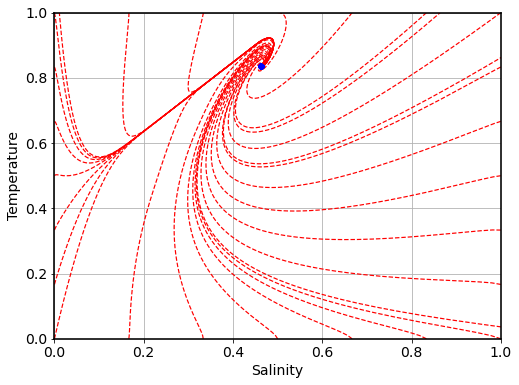

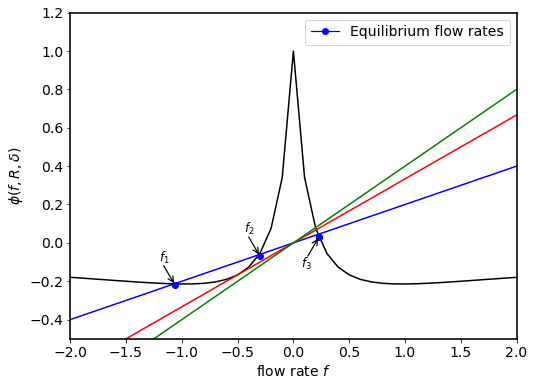

In [28]:
def main():
    set_plot_formatting()
    nn, R, delta, lambda_vals, lambda_val, q, qdelta, yres, resosc, dtau, nstep, yres0, ni, delT, delS = initialize_variables()
    print(lambda_vals)
    for lambda_valu in tqdm(lambda_vals, desc='Diagrams made'):
        x1, y1, x2, y2, x3, y3 = find_equilibrium_points(lambda_valu)
        simulate_differential_equation(nn, R, delta, lambda_valu, q, qdelta, resosc, dtau, nstep, yres0, delT, delS, x1, x2, x3, y1,y2,y3)
        calculate_and_plot_values(R, delta, lambda_val)

main()

In [38]:
def create_gif(image_folder, output_file):
    images = []
    filenames = []
    for filename in os.listdir(image_folder):
        filenames.append(filename)
    filenames = np.sort(filenames)
    print(filenames)
    for filename in filenames:
        try:
            images.append(imageio.imread(os.path.join(image_folder, filename)))
        except:
            print(f'Error in {filename}')
            pass
    imageio.mimsave(output_file, images, duration=0.075)

gif_folder_name = 'Gifs for phase portrait movie'
movie_folder_name = 'Movies for phase portrait movie'

if os.path.exists(gif_folder_name):
    pass
else:
    os.mkdir(gif_folder_name)

if os.path.exists(movie_folder_name):
    pass
else:
    os.mkdir(movie_folder_name)

create_gif('plots for phase portrait movie', gif_folder_name + '/phase_portrait.gif')

clip = mp.VideoFileClip(gif_folder_name+"/phase_portrait.gif")

clip.write_videofile(movie_folder_name+"/phase_portrait.mp4")


['phase_portrait_lambda_0.05.png'
 'phase_portrait_lambda_0.15000000000000002.png'
 'phase_portrait_lambda_0.25000000000000006.png'
 'phase_portrait_lambda_0.35000000000000003.png'
 'phase_portrait_lambda_0.45000000000000007.png']
Moviepy - Building video Movies for phase portrait movie/phase_portrait.mp4.
Moviepy - Writing video Movies for phase portrait movie/phase_portrait.mp4



Moviepy - Done !
Moviepy - video ready Movies for phase portrait movie/phase_portrait.mp4
